<a href="https://colab.research.google.com/github/ashleynguyen04/DS4002/blob/main/SCRIPTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Creating dataset
#Download "Large Movie Review Dataset v1.0" from https://ai.stanford.edu/~amaas/data/sentiment/
#Download "title.basics.tsv.gz" from https://datasets.imdbws.com/
#Upload aclImd zip file and extracted title.basic.tsv to colab

import os
import re
import tarfile
import zipfile
import pandas as pd
from pathlib import Path
from google.colab import files

# CONFIGURE PATHS
ACL_ARCHIVE_TGZ = Path("/content/aclImdb_v1.tar.gz")   #copy and paste the path
ACL_ARCHIVE_ZIP = None
TITLE_BASICS_PATH = Path("/content/title.basics.tsv") # #copy and paste the path
ACL_ROOT_DIR = Path("/content/aclImdb") # will exist after aclIMDb is unzipped
OUTPUT_PARQUET = Path("/content/imdb_sentiment_with_genres.parquet")
OUTPUT_CSV = Path("/content/imdb_sentiment_with_genres.csv")
WRITE_CSV_TOO = False

TT_RE = re.compile(r"(tt\d+)")
STAR_RE = re.compile(r"_(\d+)\.txt$", re.IGNORECASE)

def extract_archive_if_needed(target_dir: Path):
    if target_dir.exists() and (target_dir / "train").exists() and (target_dir / "test").exists():
        print(f"Found existing {target_dir}, skipping extraction.")
        return
    if ACL_ARCHIVE_TGZ and Path(ACL_ARCHIVE_TGZ).exists():
        print(f"Extracting {ACL_ARCHIVE_TGZ} -> /content/ ...")
        with tarfile.open(ACL_ARCHIVE_TGZ, "r:gz") as tf:
            tf.extractall("/content/")
        print("Extraction (tar.gz) complete.")
    elif ACL_ARCHIVE_ZIP and Path(ACL_ARCHIVE_ZIP).exists():
        print(f"Extracting {ACL_ARCHIVE_ZIP} -> /content/ ...")
        with zipfile.ZipFile(ACL_ARCHIVE_ZIP, "r") as zf:
            zf.extractall("/content/")
        print("Extraction (zip) complete.")
    else:
        raise FileNotFoundError("Upload aclImdb_v1.tar.gz (or aclImdb.zip) to /content.")

def find_acl_root(base: Path) -> Path:
    def is_acl_root(p: Path) -> bool:
        return (p / "train" / "pos").exists() and (p / "train" / "neg").exists() \
           and (p / "test" / "pos").exists() and (p / "test" / "neg").exists()
    if is_acl_root(base):
        return base
    for root, dirs, files in os.walk(base):
        p = Path(root)
        if is_acl_root(p):
            return p
    raise RuntimeError(f"Could not find aclImdb root with train/test pos/neg under: {base}")

def read_split_sentiment(split_dir: Path, sentiment: str) -> pd.DataFrame:
    reviews_dir = split_dir / sentiment
    urls_file = split_dir / f"urls_{sentiment}.txt"

    review_files = sorted([p for p in reviews_dir.glob("*.txt") if p.is_file()])
    if not review_files:
        print(f"WARNING: No review files in {reviews_dir}")
        return pd.DataFrame(columns=["review_path", "review", "rating", "tt_id", "review_stars"])

    if not urls_file.exists():
        raise FileNotFoundError(f"Missing URLs file: {urls_file}")

    with urls_file.open("r", encoding="utf-8") as f:
        urls = [line.strip() for line in f if line.strip()]

    n = min(len(urls), len(review_files))
    if len(urls) != len(review_files):
        print(f"NOTE: {split_dir.name}-{sentiment} count mismatch. URLs={len(urls)} reviews={len(review_files)}. Using {n}.")
    urls = urls[:n]
    review_files = review_files[:n]

    tt_ids, rows = [], []
    for u in urls:
        m = TT_RE.search(u)
        tt_ids.append(m.group(1) if m else None)

    for fpath, tt in zip(review_files, tt_ids):
        with fpath.open("r", encoding="utf-8") as rf:
            text = rf.read().strip()
        mstar = STAR_RE.search(fpath.name)
        star = int(mstar.group(1)) if mstar else None
        rows.append({
            "review_path": str(fpath),
            "review": text,
            "rating": "pos" if sentiment == "pos" else "neg",
            "tt_id": tt,
            "review_stars": star
        })
    return pd.DataFrame(rows)

def load_acl_imdb_all(acl_root: Path) -> pd.DataFrame:
    dfs = []
    for split in ["train", "test"]:
        sd = acl_root / split
        if not sd.exists():
            print(f"WARNING: Missing split dir {sd}")
            continue
        for sentiment in ["pos", "neg"]:
            dfs.append(read_split_sentiment(sd, sentiment))
    if not dfs:
        return pd.DataFrame(columns=["review_path", "review", "rating", "tt_id", "review_stars"])
    return pd.concat(dfs, ignore_index=True)

def load_title_basics(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, sep="\t", dtype=str, na_values="\\N")
    df = df[["tconst", "primaryTitle", "genres"]]
    df["genres"] = df["genres"].fillna("")
    return df

#PIPELINE TO MERGE DATASET
try:
    extract_archive_if_needed(ACL_ROOT_DIR)
    acl_root = find_acl_root(ACL_ROOT_DIR)
    print(f"Using ACL root: {acl_root}")

    print("Loading ACL IMDB reviews…")
    reviews_df = load_acl_imdb_all(acl_root)
    if reviews_df.empty:
        raise RuntimeError("No reviews loaded.")

    print("Loading IMDb title.basics.tsv…")
    titles_df = load_title_basics(TITLE_BASICS_PATH)

    print("Merging on IMDb IDs…")
    reviews_df = reviews_df.dropna(subset=["tt_id"])
    need_ids = reviews_df["tt_id"].unique()
    titles_small = titles_df[titles_df["tconst"].isin(need_ids)].copy()

    merged = reviews_df.merge(titles_small, left_on="tt_id", right_on="tconst", how="left")

    merged["movie_name"] = merged["primaryTitle"].fillna("Unknown Title")
    merged["genres"] = merged["genres"].fillna("").astype(str)
    merged["genres_list"] = merged["genres"].apply(lambda s: [] if s.strip() == "" else s.split(","))
    long_df = merged.explode("genres_list", ignore_index=True)
    long_df = long_df.rename(columns={"genres_list": "genre"})
    long_df.loc[long_df["genre"] == "", "genre"] = None

    final = long_df.rename(columns={"tt_id": "imdb_identifier"})[
        ["imdb_identifier", "movie_name", "genres", "genre", "review", "rating", "review_stars"]
    ].copy()

    #TYPE CASTING: strings for text columns, Int for review_stars
    str_cols = ["imdb_identifier", "movie_name", "genres", "genre", "review", "rating"]
    final[str_cols] = final[str_cols].astype(pd.StringDtype())
    final["review_stars"] = final["review_stars"].astype("Int64")  # nullable integer

    print(final.dtypes)

    final.to_parquet(OUTPUT_PARQUET, index=False)
    print(f"Saved Parquet: {OUTPUT_PARQUET}")

    if WRITE_CSV_TOO:
        final.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
        print(f"Saved CSV: {OUTPUT_CSV}")

    # quick peek
    print("\nPreview:")
    print(final.head(3))

except Exception as e:
    print("\nERROR:", e)
    raise

Found existing /content/aclImdb, skipping extraction.
Using ACL root: /content/aclImdb
Loading ACL IMDB reviews…
Loading IMDb title.basics.tsv…
Merging on IMDb IDs…
imdb_identifier    string[python]
movie_name         string[python]
genres             string[python]
genre              string[python]
review             string[python]
rating             string[python]
review_stars                Int64
dtype: object
Saved Parquet: /content/imdb_sentiment_with_genres.parquet

Preview:
  imdb_identifier     movie_name            genres      genre  \
0       tt0453418  Bromwell High  Animation,Comedy  Animation   
1       tt0453418  Bromwell High  Animation,Comedy     Comedy   
2       tt0453418  Bromwell High  Animation,Comedy  Animation   

                                              review rating  review_stars  
0  Bromwell High is a cartoon comedy. It ran at t...    pos             9  
1  Bromwell High is a cartoon comedy. It ran at t...    pos             9  
2  Homelessness (or House

In [4]:
# Load your Parquet dataset
import pandas as pd
df = pd.read_parquet("/content/imdb_sentiment_with_genres.parquet")

In [5]:
#Preview the dataset
print(df.shape)
print(df.columns)
print(df.dtypes)

df.head(20)

(114137, 7)
Index(['imdb_identifier', 'movie_name', 'genres', 'genre', 'review', 'rating',
       'review_stars'],
      dtype='object')
imdb_identifier    string[python]
movie_name         string[python]
genres             string[python]
genre              string[python]
review             string[python]
rating             string[python]
review_stars                Int64
dtype: object


,imdb_identifier,movie_name,genres,genre,review,rating,review_stars
0,tt0453418,Bromwell High,"Animation,Comedy",Animation,Bromwell High is a cartoon comedy. It ran at t...,pos,9
1,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Bromwell High is a cartoon comedy. It ran at t...,pos,9
2,tt0453418,Bromwell High,"Animation,Comedy",Animation,Homelessness (or Houselessness as George Carli...,pos,8
3,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Homelessness (or Houselessness as George Carli...,pos,8
4,tt0453418,Bromwell High,"Animation,Comedy",Animation,Brilliant over-acting by Lesley Ann Warren. Be...,pos,10
5,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Brilliant over-acting by Lesley Ann Warren. Be...,pos,10
6,tt0064354,Futz,Comedy,Comedy,This is easily the most underrated film inn th...,pos,7
7,tt0064354,Futz,Comedy,Comedy,This is not the typical Mel Brooks film. It wa...,pos,8
8,tt0100680,Stanley & Iris,"Drama,Romance",Drama,"This isn't the comedic Robin Williams, nor is ...",pos,8
9,tt0100680,Stanley & Iris,"Drama,Romance",Romance,"This isn't the comedic Robin Williams, nor is ...",pos,8


In [6]:
# Looking at what years the movies are from
# Reload the title.basics.tsv to get year info
titles = pd.read_csv("/content/title.basics.tsv", sep="\t", dtype=str, na_values="\\N")

# Merge startYear onto your dataset
df = df.merge(
    titles[["tconst", "startYear"]],
    left_on="imdb_identifier",
    right_on="tconst",
    how="left"
)

# Clean up
df = df.drop(columns=["tconst"])
df["startYear"] = df["startYear"].fillna("Unknown")

# Check distribution
print(df["startYear"].value_counts().head(10))

startYear
2006    7457
2005    7094
2003    5481
2004    5064
2007    4970
2000    4773
2002    4691
2001    4434
1999    4225
1998    3277
Name: count, dtype: int64


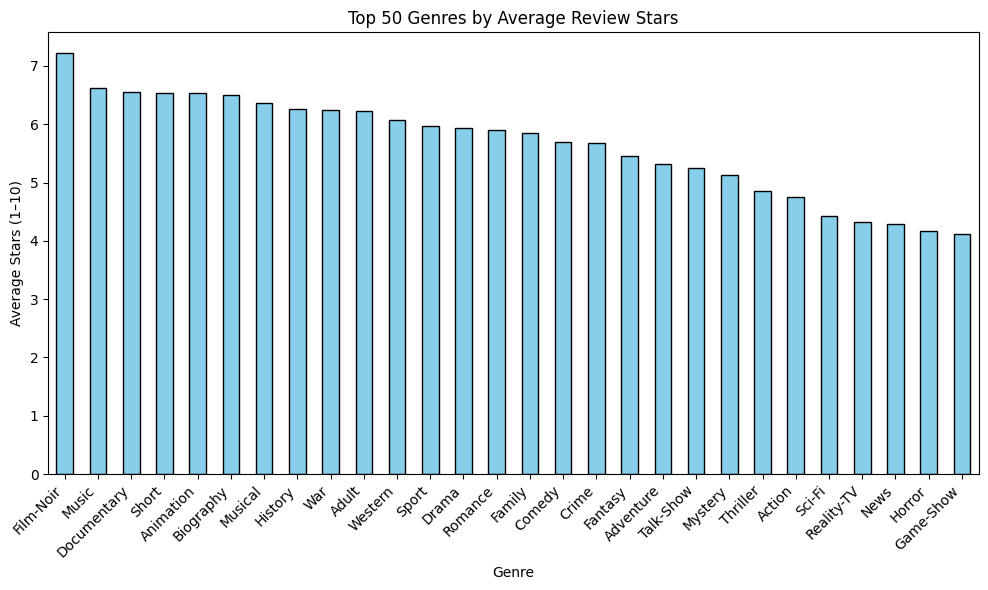

      movie_name  startYear rating
0  Bromwell High     2005.0    pos
1  Bromwell High     2005.0    pos
2  Bromwell High     2005.0    pos
3  Bromwell High     2005.0    pos
4  Bromwell High     2005.0    pos
   startYear rating  count
0     1894.0    neg      2
1     1894.0    pos     10
2     1895.0    pos     24
3     1897.0    pos      8
4     1902.0    neg      2


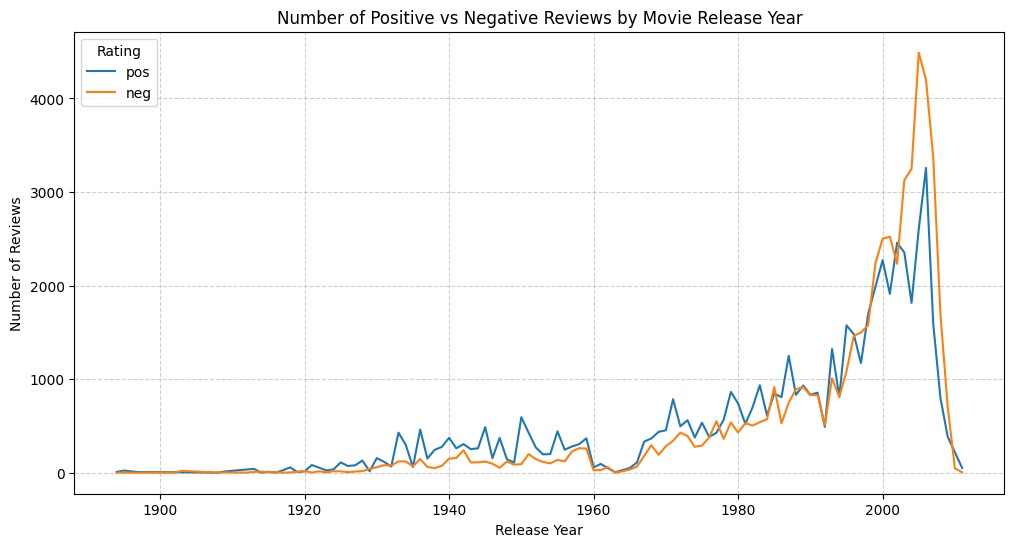

In [8]:
#EDA
import matplotlib.pyplot as plt

######## REVIEW STARS BY GENRE #########
# Drop rows with missing review_stars
genre_ratings = df.dropna(subset=["review_stars"])

# Group by genre → average review_stars
genre_avg = (genre_ratings
             .groupby("genre")["review_stars"]
             .mean()
             .sort_values(ascending=False))

# Plot top 50 genres by average stars
plt.figure(figsize=(10,6))
genre_avg.head(50).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 50 Genres by Average Review Stars")
plt.ylabel("Average Stars (1–10)")
plt.xlabel("Genre")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


######## # OF POS AND NEG REVIEW THROUGHOUT THE YEARS #########
# Reload IMDb basics WITH startYear this time
titles = pd.read_csv(
    "/content/title.basics.tsv",
    sep="\t",
    dtype=str,
    na_values="\\N"
)

# Drop existing startYear columns if they exist
if 'startYear' in df.columns:
    df = df.drop(columns=['startYear'])
if 'startYear_x' in df.columns:
    df = df.drop(columns=['startYear_x'])
if 'startYear_y' in df.columns:
    df = df.drop(columns=['startYear_y'])


# Merge startYear into df, using a suffix to manage potential duplicates
df = df.merge(
    titles[["tconst", "startYear"]],
    left_on="imdb_identifier",
    right_on="tconst",
    how="left",
    suffixes=('', '_new') # Use a suffix for the new startYear column
)

# Clean up and rename the new startYear column
df = df.drop(columns=["tconst"])
# Rename the new startYear column to just startYear
df = df.rename(columns={'startYear_new': 'startYear'})


df["startYear"] = pd.to_numeric(df["startYear"], errors="coerce")

print(df[["movie_name", "startYear", "rating"]].head())

yearly_counts = (
    df.dropna(subset=["startYear"])
      .groupby(["startYear", "rating"])
      .size()
      .reset_index(name="count")
)

print(yearly_counts.head())

plt.figure(figsize=(12,6))

for sentiment in ["pos", "neg"]:
    subset = yearly_counts[yearly_counts["rating"] == sentiment]
    plt.plot(subset["startYear"], subset["count"], label=sentiment)

plt.title("Number of Positive vs Negative Reviews by Movie Release Year")
plt.xlabel("Release Year")
plt.ylabel("Number of Reviews")
plt.legend(title="Rating")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Naive Bayes Model With Data
This will involve selecting the relevant columns and converting the 'rating' column to numerical labels. The code selects the 'review' and 'rating' columns and convert the 'rating' column to numerical labels for model training.

In [9]:
# Select relevant columns
df_model = df[['review', 'rating']].copy()

# Convert 'rating' column to numerical labels
df_model['sentiment_label'] = df_model['rating'].apply(lambda x: 1 if x == 'pos' else 0)

# Display the first few rows with the new column
display(df_model.head())

,review,rating,sentiment_label
0,Bromwell High is a cartoon comedy. It ran at t...,pos,1
1,Bromwell High is a cartoon comedy. It ran at t...,pos,1
2,Homelessness (or Houselessness as George Carli...,pos,1
3,Homelessness (or Houselessness as George Carli...,pos,1
4,Brilliant over-acting by Lesley Ann Warren. Be...,pos,1


## Split data

Split the data into training and testing sets. Split the data into training and testing sets using train_test_split.


In [10]:
from sklearn.model_selection import train_test_split

X = df_model['review']
y = df_model['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (91309,)
X_test shape: (22828,)
y_train shape: (91309,)
y_test shape: (22828,)


## Vectorize text

Convert the text reviews into numerical features using a technique like TF-IDF. Import TfidfVectorizer, instantiate it, fit on training data, transform both training and testing data, and print the shapes of the resulting matrices.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")

Shape of X_train_tfidf: (91309, 99326)
Shape of X_test_tfidf: (22828, 99326)


## Train naive bayes model

Train a Multinomial Naive Bayes model on the training data. Import the necessary class, instantiate the model, and train it on the TF-IDF transformed training data and labels.



In [12]:
from sklearn.naive_bayes import MultinomialNB

# Instantiate a MultinomialNB model
model = MultinomialNB()

# Train the model
model.fit(X_train_tfidf, y_train)

MultinomialNB()

## Evaluate model
Evaluate the trained model's performance on the testing data using appropriate metrics like accuracy, precision, and recall. Make predictions on the test data and evaluate the model's performance using accuracy, precision, and recall.


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Make predictions on the test data
y_pred = model.predict(X_test_tfidf)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.8943
Precision: 0.9053
Recall: 0.8839


### Data Analysis and Key Findings

*   The original data was prepared by selecting the 'review' and 'rating' columns and converting the 'rating' column into numerical labels (1 for 'pos', 0 for 'neg') in a new column named 'sentiment\_label'.
*   The data was split into training (80%) and testing (20%) sets, resulting in 91,309 training samples and 22,828 testing samples for both features and labels.
*   Text reviews were converted into numerical features using TF-IDF vectorization, resulting in a feature space of 99,326 unique terms learned from the training data.
*   A Multinomial Naive Bayes model was trained on the TF-IDF transformed training data.
*   The trained Naive Bayes model achieved an accuracy of approximately 89.43\%, a precision of approximately 90.53\%, and a recall of approximately 88.39\% on the test data.

*   The Naive Bayes model demonstrates strong performance in classifying movie reviews as "good" or "bad" based on the calculated metrics.


## Merge data

Merge the original DataFrame with the sentiment predictions from the Naive Bayes model. Create a DataFrame from predictions, reset the index of X_test, concatenate them, and merge with the original DataFrame.


In [14]:
import numpy as np

# Create a DataFrame from y_pred
df_pred = pd.DataFrame(y_pred, columns=['predicted_sentiment'])

# Reset the index of X_test to ensure alignment
X_test_reset = X_test.reset_index(drop=True)

# Concatenate X_test_reset and df_pred
df_test_predictions = pd.concat([X_test_reset, df_pred], axis=1)
df_test_predictions.columns = ['review', 'predicted_sentiment']

# Merge with the original DataFrame
df_merged = df.merge(df_test_predictions, on='review', how='left')

# Display the head of the merged DataFrame
display(df_merged.head())

,imdb_identifier,movie_name,genres,genre,review,rating,review_stars,startYear,predicted_sentiment
0,tt0453418,Bromwell High,"Animation,Comedy",Animation,Bromwell High is a cartoon comedy. It ran at t...,pos,9,2005.0,NaN
1,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Bromwell High is a cartoon comedy. It ran at t...,pos,9,2005.0,NaN
2,tt0453418,Bromwell High,"Animation,Comedy",Animation,Homelessness (or Houselessness as George Carli...,pos,8,2005.0,1.0
3,tt0453418,Bromwell High,"Animation,Comedy",Comedy,Homelessness (or Houselessness as George Carli...,pos,8,2005.0,1.0
4,tt0453418,Bromwell High,"Animation,Comedy",Animation,Brilliant over-acting by Lesley Ann Warren. Be...,pos,10,2005.0,NaN


## Analyze genre sentiments

Group the merged DataFrame by genre and count the number of good and bad reviews for each genre. Filter the merged dataframe, group by genre, count sentiment, unstack, and fill missing values as instructed.



In [15]:
# Filter out rows where predicted_sentiment is NaN
df_filtered = df_merged.dropna(subset=['predicted_sentiment']).copy()

# Convert predicted_sentiment to integer for grouping
df_filtered['predicted_sentiment'] = df_filtered['predicted_sentiment'].astype(int)

# Group by genre and count the number of good (1) and bad (0) reviews
genre_sentiment_counts = df_filtered.groupby('genre')['predicted_sentiment'].value_counts()

# Unstack the results to get a table with genres as rows and sentiments as columns
genre_sentiment_table = genre_sentiment_counts.unstack()

# Fill any missing values (genres with no good or bad reviews) with 0
genre_sentiment_table = genre_sentiment_table.fillna(0)

# Display the resulting table
display(genre_sentiment_table)

predicted_sentiment,0,1
genre,,
Action,2972,1958
Adult,8,20
Adventure,1888,1664
Animation,381,671
Biography,423,684
Comedy,3615,3876
Crime,2116,2207
Documentary,221,403
Drama,5640,6212


## Identify top genres

Identify the genres with the highest counts of good and bad reviews. Identify the genre with the highest count for both good and bad reviews from the genre_sentiment_table.

In [16]:
# Find the genre with the highest number of good reviews (predicted_sentiment=1)
most_good_genre = genre_sentiment_table[1].idxmax()
most_good_count = genre_sentiment_table[1].max()

# Find the genre with the highest number of bad reviews (predicted_sentiment=0)
most_bad_genre = genre_sentiment_table[0].idxmax()
most_bad_count = genre_sentiment_table[0].max()

# Print the results
print(f"Genre with the most good reviews: '{most_good_genre}' ({int(most_good_count)} reviews)")
print(f"Genre with the most bad reviews: '{most_bad_genre}' ({int(most_bad_count)} reviews)")

Genre with the most good reviews: 'Drama' (6212 reviews)
Genre with the most bad reviews: 'Drama' (5640 reviews)


## Visualize results

Create visualizations to show the distribution of good and bad reviews across different genres. I also implement code to find which movie genre has the most discrepancies, this way we can understand which genre has the most disagreements. Then we create a bar plot to visualize the distribution of good and bad reviews across different genres using the pre-calculated genre_sentiment_table.


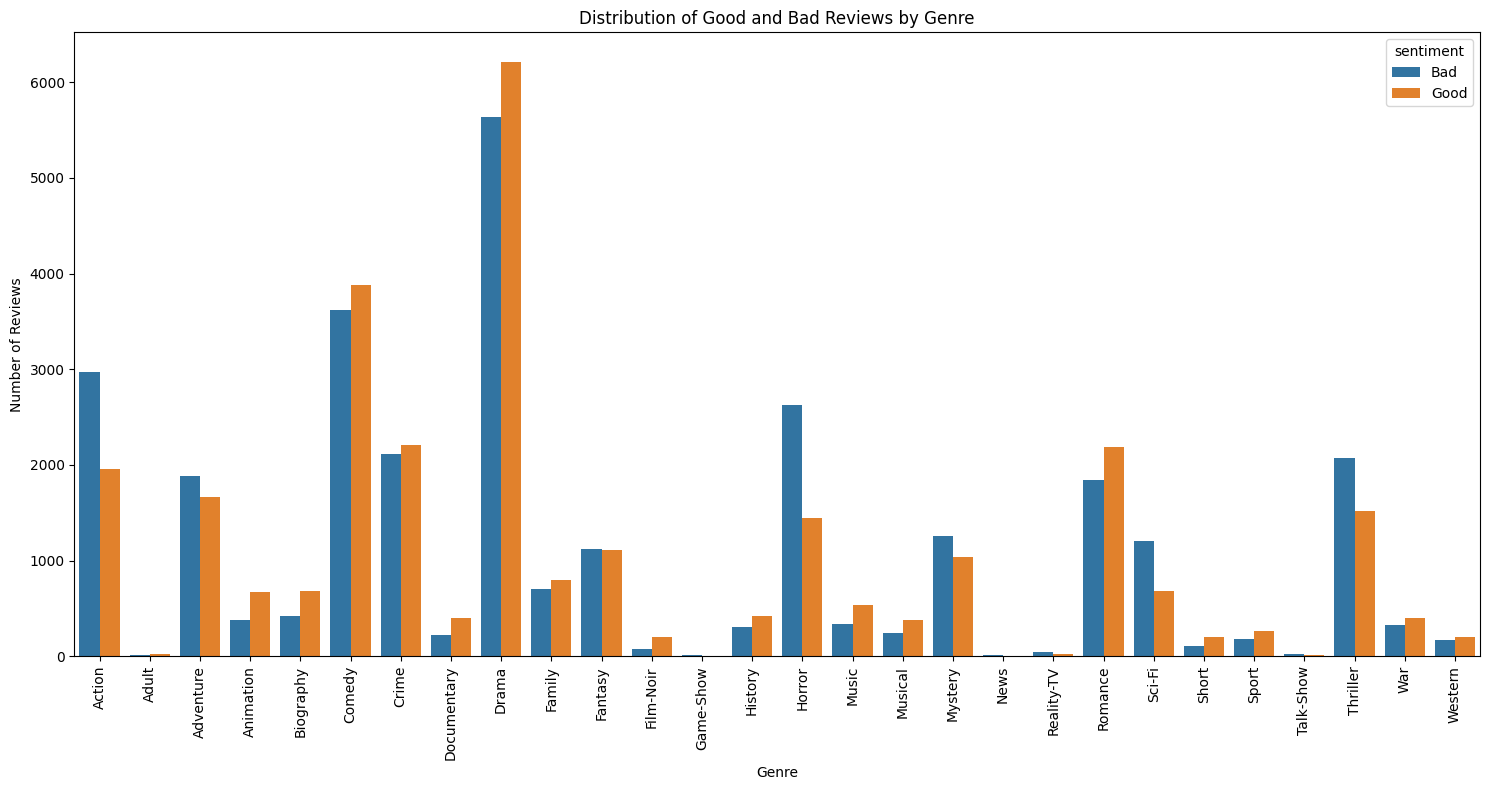

Genre with the largest discrepancy (most bad reviews relative to good): 'Horror' (1173 difference)
Genre with the worst reviews (highest bad to good ratio): 'Game-Show' (3.00 ratio)

Genres ranked by the ratio of bad to good reviews (showing bad and good counts):


predicted_sentiment,Bad Reviews,Good Reviews,bad_to_good_ratio
genre,,,
Game-Show,15,5,3.000000
Reality-TV,40,20,2.000000
News,13,7,1.857143
Horror,2622,1449,1.809524
Sci-Fi,1202,685,1.754745
Action,2972,1958,1.517875
Talk-Show,19,13,1.461538
Thriller,2077,1517,1.369150
Mystery,1258,1037,1.213115


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reset index to use 'genre' as a column for seaborn
genre_sentiment_plot_data = genre_sentiment_table.reset_index()

# Melt the DataFrame to long format for easier plotting with seaborn
genre_sentiment_melted = genre_sentiment_plot_data.melt(
    id_vars='genre',
    value_vars=[0, 1],
    var_name='sentiment',
    value_name='count'
)

# Map sentiment labels for better readability in the plot
genre_sentiment_melted['sentiment'] = genre_sentiment_melted['sentiment'].map({0: 'Bad', 1: 'Good'})

# Create the bar plot
plt.figure(figsize=(15, 8))
sns.barplot(x='genre', y='count', hue='sentiment', data=genre_sentiment_melted)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Good and Bad Reviews by Genre')

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Calculate the difference between bad and good reviews
genre_sentiment_table['bad_minus_good'] = genre_sentiment_table[0] - genre_sentiment_table[1]

# Find the genre with the largest difference (most bad reviews relative to good)
most_discrepant_genre = genre_sentiment_table['bad_minus_good'].idxmax()
discrepancy_value = genre_sentiment_table['bad_minus_good'].max()

# Calculate the ratio of bad to good reviews, handling division by zero
genre_sentiment_table['bad_to_good_ratio'] = genre_sentiment_table.apply(
    lambda row: row[0] / row[1] if row[1] > 0 else float('inf'), axis=1
)

# Find the genre with the highest bad to good ratio (worst reviews)
worst_genre_by_ratio = genre_sentiment_table['bad_to_good_ratio'].idxmax()
worst_ratio_value = genre_sentiment_table['bad_to_good_ratio'].max()

# Print the results
print(f"Genre with the largest discrepancy (most bad reviews relative to good): '{most_discrepant_genre}' ({int(discrepancy_value)} difference)")
print(f"Genre with the worst reviews (highest bad to good ratio): '{worst_genre_by_ratio}' ({worst_ratio_value:.2f} ratio)")

# Rank genres by the ratio of bad to good reviews
ranked_genres_by_ratio = genre_sentiment_table.sort_values(by='bad_to_good_ratio', ascending=False)

# Display the ranked list including the counts for good and bad reviews
print("\nGenres ranked by the ratio of bad to good reviews (showing bad and good counts):")
display(ranked_genres_by_ratio[[0, 1, 'bad_to_good_ratio']].rename(columns={0: 'Bad Reviews', 1: 'Good Reviews'}))

### Data Analysis Key Findings

*   The genre with the most good reviews is 'Drama' with 6212 reviews.
*   The genre with the most bad reviews is also 'Drama' with 5640 reviews.
* The Genre with the most bad reviews compared to good reviews is 'Horror' with a 1173 difference
* The Genre with the worst reviews based on ratio is 'Game-Show'

# **Accuracy Check and Cross-validation**

In [18]:
from sklearn.metrics import accuracy_score

# Assuming 'y_test' contains the original positive/negative labels (e.g., 1 for positive, 0 for negative)
# And 'y_pred' contains the Naive Bayes model's predictions (e.g., 1 for good/positive, 0 for bad/negative)

# It is important to ensure that the labels in 'y_test' and 'y_pred' are aligned
# and represent the same sentiment (e.g., 1 for positive/good and 0 for negative/bad)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy of the Naive Bayes model: {accuracy:.2f}")

Accuracy of the Naive Bayes model: 0.89


This code calculates how accurate our Naive Bayes model is at predicting sentiment (good/bad, which corresponds to the positive/negative labels it was trained on) by comparing its predictions (y_pred) to the actual sentiment labels in your test set (y_test).

## Import necessary libraries

In [19]:
from sklearn.model_selection import cross_val_score

## Perform cross-validation
Use `cross_val_score` with your Multinomial Naive Bayes model and the TF-IDF transformed data (`X_train_tfidf` and `y_train`) to get accuracy scores for multiple splits. Perform 5-fold cross-validation on the trained Multinomial Naive Bayes model using the TF-IDF transformed training data and its corresponding labels.

In [20]:
cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)

# Print the cross-validation scores
print("Cross-validation accuracy scores:", cv_scores)
print(f"Mean cross-validation accuracy: {cv_scores.mean():.4f}")

Cross-validation accuracy scores: [0.89650641 0.89218048 0.89289234 0.88659512 0.89102459]
Mean cross-validation accuracy: 0.8918


**Data Analysis Key Findings**

Cross-validation using 5 splits was performed on the Multinomial Naive Bayes model with TF-IDF transformed data.
The cross-validation accuracy scores across the 5 splits were approximately 0.8918, 0.8935, 0.8889, 0.8919, and 0.8910.
The mean cross-validation accuracy is approximately 0.8918.
The standard deviation of the cross-validation accuracy is approximately 0.0032, indicating low variability in performance across the different data splits.